# Ranking System

This notebook is used to create a ranking system to select:
- the overall top 100 reputable and reliable merchants;
- top 10 reputable and reliable merchants for each segment (following are all merchant segments).
  -  Personal Care and Repair Services (1)
  -  Arts (2)
  -  Home and Furniture (3)
  -  Gifts and Souvenirs (4)
  -  Technology and Electronic Equipment (5)

We will firstly add new features then build a model for ranking systems.

---

In [51]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import* 
from pyspark.sql import functions as F
from functools import reduce
from pyspark.sql.functions import col, count, when, isnull, first
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
import matplotlib.pyplot as plt

In [85]:
spark = (
    SparkSession.builder.appName("Ranking")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.debug.maxToStringFields", 6000)
    .config("spark.network.timeout", "300s")
    .config("spark.driver.maxResultSize", "4g")
    .config("spark.rpc.askTimeout", "300s")
    .config("spark.driver.memory", "8G")
    .config("spark.executor.memory", "8G")
    .getOrCreate()
)

# Read dataset

In [53]:
full_transaction = spark.read.parquet('../data/curated/full_transaction_with_segments')

In [54]:
full_transaction.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_id: string (nullable = true)
 |-- take_rate: float (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- transaction_revenue: double (nullable = true)
 |-- BNPL_revenue: double (nullable = true)
 |-- revenue_level_e: integer (nullable = true)
 |-- revenue_level_d: integer (nullable = true)
 |-- revenue_level_c: integer (nullable = true)
 |-- revenue_level_b: integer (nullable = true)
 |-- revenue_level_a: integer (nullable = true)
 |-- category_jewelry: integer (nullable = true)
 |-- category_art: integer (nullable = true)
 |-- category_television: integer (nullable = true)
 |-- category_watch: integer (nullable = true)
 |-- category_cable: integer (nullable = true)
 |-- category_repair: integer (nullable = true)
 |-- category_stock: integer (nullable = true)
 |-- category_flower: integer (nullable = true)
 |-- category_office: integer (nullable = true)
 |-- category_souvenir: integer (nullable = true)

# Add new features

### Customer Purchasing Power

In [55]:
customer_purchasing = full_transaction.select("merchant_abn", "dollar_value", "user_id")
customer_purchasing.show(5)

+------------+------------------+-------+
|merchant_abn|      dollar_value|user_id|
+------------+------------------+-------+
| 10023283211| 471.0728368548525|  12989|
| 10023283211| 175.5210411776095|  14228|
| 10023283211|161.58285610603005|  23580|
| 10023283211|117.13654104775188|  13300|
| 10023283211| 146.8380452902161|  22397|
+------------+------------------+-------+
only showing top 5 rows



In [56]:
# Group by `merchant_abn` and `user_id`,
# and calculate total spending and average spending per transaction
customer_purchasing_power = (
    customer_purchasing
    .groupBy("merchant_abn", "user_id")
    .agg(
        # Calculate the average spending per transaction
        F.avg("dollar_value").alias("customer_purchasing_power") 
    )
)
customer_purchasing_power.show(5)

+------------+-------+-------------------------+
|merchant_abn|user_id|customer_purchasing_power|
+------------+-------+-------------------------+
| 10206519221|   5556|        73.69453931939448|
| 10206519221|  17553|         47.0693707286691|
| 10264435225|  12856|        49.33107867890681|
| 10487253336|  22215|        418.2064429778674|
| 10487253336|  17837|        748.6677899020842|
+------------+-------+-------------------------+
only showing top 5 rows



In [57]:
# Group by merchant_abn and calculate the average of customer_purchasing_power
merchant_avg_purchasing_power = (
    customer_purchasing_power
    .groupBy("merchant_abn")
    .agg(
        # Calculate average purchasing power for each merchant
        F.avg("customer_purchasing_power").alias("avg_purchasing_power") 
    )
)
merchant_avg_purchasing_power.show(5)

+------------+--------------------+
|merchant_abn|avg_purchasing_power|
+------------+--------------------+
| 35344855546|   89.26560865171946|
| 38700038932|  1346.0099129373211|
| 83412691377|   34.97769422797056|
| 73256306726|  284.83119504700403|
| 15613631617|  303.62604920936644|
+------------+--------------------+
only showing top 5 rows



In [58]:
# Merge the `avg_purchasing_power` to `full_transactions`
full_transaction = full_transaction.join(
    merchant_avg_purchasing_power, 
    on=["merchant_abn"], 
    how="inner"
).select(
    full_transaction["*"], 
    merchant_avg_purchasing_power["avg_purchasing_power"]
)
full_transaction.show(5)

+------------+--------------------+---------+--------------------------+-------------------+------------------+---------------+---------------+---------------+---------------+---------------+----------------+------------+-------------------+--------------+--------------+---------------+--------------+---------------+---------------+-----------------+---------------+----------------+----------------+-------------------+------------+----------------+------------------+-------------+-------------+---------------+---------------+-------------+--------------+--------------------+--------------+-------------------+-----------------+--------------+-----------------+--------------+-------------------+--------------+---------------+---------------+-------------+--------------+-------------------+--------------+--------------+----------------+-------------+-------------+---------------+---------------+----------------+----------------+---------------+------------------+----------------+---------

### Customer Repurchase Rate

In [59]:
# Group by merchant_abn and user_id, calculate the number of transactions per customer for each merchant
customer_purchase_counts = full_transaction.groupBy("merchant_abn", "user_id").agg(
    F.countDistinct("order_datetime").alias("purchase_count")  # Calculate distinct transaction dates per customer
)
customer_purchase_counts.show(5)

+------------+-------+--------------+
|merchant_abn|user_id|purchase_count|
+------------+-------+--------------+
| 12516851436|  19570|             1|
| 12516851436|  20636|             1|
| 12516851436|  18374|             1|
| 12516851436|   5785|             1|
| 12516851436|  20400|             1|
+------------+-------+--------------+
only showing top 5 rows



In [60]:
# Calculate the number of repurchase users and total users per merchant
repurchase_data = customer_purchase_counts.groupBy("merchant_abn") \
    .agg(
        F.sum(F.when(F.col("purchase_count") > 1, 1).otherwise(0)).alias("repurchase_count"),  # Count of repurchase users
        F.count("user_id").alias("total_users")  # Total number of users
    )

# Calculate the repurchase rate
repurchase_data = repurchase_data.withColumn("repurchase_rate", 
    F.col("repurchase_count") / F.col("total_users"))

# Sort by repurchase rate in descending order
sorted_repurchase_data = repurchase_data.orderBy(F.col("repurchase_rate").desc())

# Drop the intermediate columns: repurchase_count and total_users
sorted_repurchase_data = sorted_repurchase_data.drop("repurchase_count", "total_users")
sorted_repurchase_data.show(5)

+------------+------------------+
|merchant_abn|   repurchase_rate|
+------------+------------------+
| 86578477987|0.9999003884849088|
| 24852446429|0.9999003835234348|
| 64203420245|0.9998505827273633|
| 49891706470|0.9997011356843993|
| 46804135891|0.9993524606495318|
+------------+------------------+
only showing top 5 rows



In [61]:
# Merge the `repurchase_rate` to `full_transactions`
full_transaction = full_transaction.join(
    sorted_repurchase_data, 
    on=["merchant_abn"], 
    how="inner"
).select(
    full_transaction["*"], 
    sorted_repurchase_data["repurchase_rate"]
)
full_transaction.show(5)

+------------+--------------------+---------+--------------------------+-------------------+-------------------+---------------+---------------+---------------+---------------+---------------+----------------+------------+-------------------+--------------+--------------+---------------+--------------+---------------+---------------+-----------------+---------------+----------------+----------------+-------------------+------------+----------------+------------------+-------------+-------------+---------------+---------------+-------------+--------------+--------------------+--------------+-------------------+-----------------+--------------+-----------------+--------------+-------------------+--------------+---------------+---------------+-------------+--------------+-------------------+--------------+--------------+----------------+-------------+-------------+---------------+---------------+----------------+----------------+---------------+------------------+----------------+--------

# Aggregation of Numerical Features by merchant_abn

In [62]:
numerical_transaction = full_transaction.select("merchant_abn", 
                                                "merchant_fraud_probability", 
                                                "transaction_revenue", 
                                                "BNPL_revenue", "consumer_fraud_probability", 
                                                "average_population", "avg_age_persons", 
                                                "avg_mortgage_repay_monthly", 
                                                "avg_tot_prsnl_inc_weekly", 
                                                "avg_rent_weekly", "avg_tot_fam_inc_weekly", 
                                                "avg_num_psns_per_bedroom", 
                                                "avg_tot_hhd_inc_weekly", 
                                                "avg_household_size", "avg_unemployment_rate",
                                                "repurchase_rate", "avg_purchasing_power")

In [63]:
# Group by 'merchant_abn' and aggregate
numerical_transaction  = numerical_transaction.groupBy("merchant_abn").agg(
    # Average for the specified columns
    F.avg("merchant_fraud_probability").alias("avg_merchant_fraud_probability"),
    F.avg("consumer_fraud_probability").alias("avg_consumer_fraud_probability"),
    F.avg("average_population").alias("avg_average_population"),
    F.avg("avg_age_persons").alias("avg_age_persons"),
    F.avg("avg_mortgage_repay_monthly").alias("avg_mortgage_repay_monthly"),
    F.avg("avg_tot_prsnl_inc_weekly").alias("avg_tot_prsnl_inc_weekly"),
    F.avg("avg_rent_weekly").alias("avg_rent_weekly"),
    F.avg("avg_tot_fam_inc_weekly").alias("avg_tot_fam_inc_weekly"),
    F.avg("avg_num_psns_per_bedroom").alias("avg_num_psns_per_bedroom"),
    F.avg("avg_tot_hhd_inc_weekly").alias("avg_tot_hhd_inc_weekly"),
    F.avg("avg_household_size").alias("avg_household_size"),
    F.avg("repurchase_rate").alias("avg_repurchase_rate"),
    F.avg("avg_purchasing_power").alias("avg_purchasing_power"),

    # Sum for the transaction revenue and BNPL revenue
    F.sum("transaction_revenue").alias("total_transaction_revenue"),
    F.sum("BNPL_revenue").alias("total_BNPL_revenue")
)

# Display the result
numerical_transaction.show(5)

+------------+------------------------------+------------------------------+----------------------+-----------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+--------------------+--------------------+-------------------------+------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|  avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size| avg_repurchase_rate|avg_purchasing_power|total_transaction_revenue|total_BNPL_revenue|
+------------+------------------------------+------------------------------+----------------------+-----------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+---------

# Aggregation of Categorical Features by merchant_abn

In [64]:
categorical_transaction = full_transaction.select("merchant_abn", "revenue_level_e", 
                                                  "revenue_level_d", "revenue_level_c", 
                                                  "revenue_level_b", "revenue_level_a", 
                                                  "state_NT", "state_ACT", "state_SA", 
                                                  "state_TAS", "state_WA", "state_QLD", 
                                                  "state_VIC", "state_NSW", "gender_Undisclosed", 
                                                  "gender_Female", "gender_Male", 
                                                  "consumer_is_fraud",
                                                  "transaction_is_fraud", "merchant_segment_1", 
                                                  "merchant_segment_3", "merchant_segment_5", 
                                                  "merchant_segment_4", "merchant_segment_2")
categorical_transaction.show(5)

+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|merchant_abn|revenue_level_e|revenue_level_d|revenue_level_c|revenue_level_b|revenue_level_a|state_NT|state_ACT|state_SA|state_TAS|state_WA|state_QLD|state_VIC|state_NSW|gender_Undisclosed|gender_Female|gender_Male|consumer_is_fraud|transaction_is_fraud|merchant_segment_1|merchant_segment_3|merchant_segment_5|merchant_segment_4|merchant_segment_2|
+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+-----------------+--------------------+------------------+------------------+-----

In [65]:
# Group by merchant_abn and take the first record for each ABN
categorical_transaction = categorical_transaction.groupBy("merchant_abn").agg(
    first("revenue_level_e").alias("revenue_level_e"),       # Get the first revenue_level_e for each merchant_abn
    first("revenue_level_d").alias("revenue_level_d"),       # Get the first revenue_level_d for each merchant_abn
    first("revenue_level_c").alias("revenue_level_c"),       # Get the first revenue_level_c for each merchant_abn
    first("revenue_level_b").alias("revenue_level_b"),       # Get the first revenue_level_b for each merchant_abn
    first("revenue_level_a").alias("revenue_level_a"),       # Get the first revenue_level_a for each merchant_abn
    first("state_NT").alias("state_NT"),                     # Get the first state_NT for each merchant_abn
    first("state_ACT").alias("state_ACT"),                   # Get the first state_ACT for each merchant_abn
    first("state_SA").alias("state_SA"),                     # Get the first state_SA for each merchant_abn
    first("state_TAS").alias("state_TAS"),                   # Get the first state_TAS for each merchant_abn
    first("state_WA").alias("state_WA"),                     # Get the first state_WA for each merchant_abn
    first("state_QLD").alias("state_QLD"),                   # Get the first state_QLD for each merchant_abn
    first("state_VIC").alias("state_VIC"),                   # Get the first state_VIC for each merchant_abn
    first("state_NSW").alias("state_NSW"),                   # Get the first state_NSW for each merchant_abn
    first("gender_Undisclosed").alias("gender_Undisclosed"), # Get the first gender_Undisclosed for each merchant_abn
    first("gender_Female").alias("gender_Female"),           # Get the first gender_Female for each merchant_abn
    first("gender_Male").alias("gender_Male"),               # Get the first gender_Male for each merchant_abn
    first("consumer_is_fraud").alias("consumer_is_fraud"),   # Get the first consumer_is_fraud for each merchant_abn
    first("transaction_is_fraud").alias("transaction_is_fraud"),  # Get the first transaction_is_fraud for each merchant_abn
    first("merchant_segment_1").alias("merchant_segment_1"), # Get the first merchant_segment_1 for each merchant_abn
    first("merchant_segment_3").alias("merchant_segment_3"), # Get the first merchant_segment_3 for each merchant_abn
    first("merchant_segment_5").alias("merchant_segment_5"), # Get the first merchant_segment_5 for each merchant_abn
    first("merchant_segment_4").alias("merchant_segment_4"), # Get the first merchant_segment_4 for each merchant_abn
    first("merchant_segment_2").alias("merchant_segment_2")  # Get the first merchant_segment_2 for each merchant_abn
)

categorical_transaction.show(5)

+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|merchant_abn|revenue_level_e|revenue_level_d|revenue_level_c|revenue_level_b|revenue_level_a|state_NT|state_ACT|state_SA|state_TAS|state_WA|state_QLD|state_VIC|state_NSW|gender_Undisclosed|gender_Female|gender_Male|consumer_is_fraud|transaction_is_fraud|merchant_segment_1|merchant_segment_3|merchant_segment_5|merchant_segment_4|merchant_segment_2|
+------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+-----------------+--------------------+------------------+------------------+-----

# Merge Two Aggregated Tables

In [66]:
# Merge the `numerical_transaction` and `categorical_transaction`
aggregated_transaction_by_merchant = numerical_transaction.join(
    categorical_transaction, 
    on=["merchant_abn"], 
    how="inner"
)
aggregated_transaction_by_merchant.show(5)

+------------+------------------------------+------------------------------+----------------------+-----------------+--------------------------+------------------------+------------------+----------------------+------------------------+----------------------+------------------+--------------------+--------------------+-------------------------+------------------+---------------+---------------+---------------+---------------+---------------+--------+---------+--------+---------+--------+---------+---------+---------+------------------+-------------+-----------+-----------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|merchant_abn|avg_merchant_fraud_probability|avg_consumer_fraud_probability|avg_average_population|  avg_age_persons|avg_mortgage_repay_monthly|avg_tot_prsnl_inc_weekly|   avg_rent_weekly|avg_tot_fam_inc_weekly|avg_num_psns_per_bedroom|avg_tot_hhd_inc_weekly|avg_household_size| avg_repurchase_rate

### Check the shape of aggregated dataset

In [67]:
num_rows = aggregated_transaction_by_merchant.count()
print(f"Number of rows: {num_rows}")

num_columns = len(aggregated_transaction_by_merchant.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 4026
Number of columns: 39


In [68]:
aggregated_transaction_by_merchant.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- avg_merchant_fraud_probability: double (nullable = true)
 |-- avg_consumer_fraud_probability: double (nullable = true)
 |-- avg_average_population: double (nullable = true)
 |-- avg_age_persons: double (nullable = true)
 |-- avg_mortgage_repay_monthly: double (nullable = true)
 |-- avg_tot_prsnl_inc_weekly: double (nullable = true)
 |-- avg_rent_weekly: double (nullable = true)
 |-- avg_tot_fam_inc_weekly: double (nullable = true)
 |-- avg_num_psns_per_bedroom: double (nullable = true)
 |-- avg_tot_hhd_inc_weekly: double (nullable = true)
 |-- avg_household_size: double (nullable = true)
 |-- avg_repurchase_rate: double (nullable = true)
 |-- avg_purchasing_power: double (nullable = true)
 |-- total_transaction_revenue: double (nullable = true)
 |-- total_BNPL_revenue: double (nullable = true)
 |-- revenue_level_e: integer (nullable = true)
 |-- revenue_level_d: integer (nullable = true)
 |-- revenue_level_c: integer (nullable = true)

# Create the Ranking System

### Feature importances by Gradient Boosting

In [69]:
# select features for training
feature_columns = [col for col in aggregated_transaction_by_merchant.columns if col not in ['transaction_is_fraud', 'merchant_abn']]

# create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
labeled_data = assembler.transform(aggregated_transaction_by_merchant)
unlabeled_data = assembler.transform(aggregated_transaction_by_merchant)

# standardise features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withMean=True, withStd=True)

# standardise labeled and unlabeled datasets
scaler_model = scaler.fit(labeled_data)
labeled_data = scaler_model.transform(labeled_data)
unlabeled_data = scaler_model.transform(unlabeled_data)

# train the model
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='transaction_is_fraud', maxIter=100)
model = gbt.fit(labeled_data)

# get the feature importances
feature_importances = model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importances))

# sort the feature importances
sorted_feature_importances = sorted(feature_importance_dict.items(), 
                                    key=lambda x: x[1], reverse=True)
print("Feature importance:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

24/10/01 21:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1000.9 KiB
24/10/01 21:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
24/10/01 21:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
24/10/01 21:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
24/10/01 21:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1004.9 KiB
24/10/01 21:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
24/10/01 21:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1009.1 KiB
24/10/01 21:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
24/10/01 21:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
24/10/01 21:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
24/10/01 21:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1013.2 KiB
24/10/01 21:15:05 WAR

Feature importance:
avg_merchant_fraud_probability: 0.7551092104972196
consumer_is_fraud: 0.04130393170245614
total_transaction_revenue: 0.01885380304389787
avg_purchasing_power: 0.01713911840019116
avg_mortgage_repay_monthly: 0.016289607333590517
avg_consumer_fraud_probability: 0.014600765305549624
total_BNPL_revenue: 0.014500546368114516
avg_num_psns_per_bedroom: 0.013045921673920472
avg_average_population: 0.012758794292810701
avg_repurchase_rate: 0.011911521752976422
merchant_segment_1: 0.011898111663611596
avg_tot_prsnl_inc_weekly: 0.011628697269639254
avg_household_size: 0.009504289069735924
revenue_level_a: 0.007866446489606637
avg_tot_hhd_inc_weekly: 0.007623764864538863
avg_age_persons: 0.0070661300247966425
avg_tot_fam_inc_weekly: 0.006335494668592945
revenue_level_c: 0.00601716200263575
avg_rent_weekly: 0.0038020120037136353
state_WA: 0.003599661521896741
gender_Undisclosed: 0.002069651748054352
state_TAS: 0.001432214963273191
revenue_level_b: 0.0013682759222298096
state_NSW

24/10/01 21:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1248.8 KiB


### Feature importances by Random Forest

In [70]:
# Select features for training
feature_columns = [col for col in aggregated_transaction_by_merchant.columns if col != 'transaction_is_fraud']

# Create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
labeled_data = assembler.transform(aggregated_transaction_by_merchant)
unlabeled_data = assembler.transform(aggregated_transaction_by_merchant)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withMean=True, withStd=True)

# Standardize labeled and unlabeled datasets
scaler_model = scaler.fit(labeled_data)
labeled_data = scaler_model.transform(labeled_data)
unlabeled_data = scaler_model.transform(unlabeled_data)

# Train the RandomForest model
rf = RandomForestRegressor(featuresCol='scaled_features', labelCol='transaction_is_fraud', numTrees=100)
rf_model = rf.fit(labeled_data)

# Get the feature importances
feature_importances = rf_model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importances))

# Sort the feature importances
sorted_feature_importances = sorted(feature_importance_dict.items(), 
                                    key=lambda x: x[1], reverse=True)
print("Feature importance:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature importance:
avg_merchant_fraud_probability: 0.8696436306450885
consumer_is_fraud: 0.03764393753990681
avg_purchasing_power: 0.03249644699379255
merchant_segment_5: 0.015939674265483296
merchant_segment_4: 0.007091514527985627
revenue_level_e: 0.006178221021911205
revenue_level_a: 0.005863930982942556
revenue_level_b: 0.004296771411477934
merchant_segment_3: 0.003977442648357645
merchant_segment_2: 0.002302026930819342
avg_consumer_fraud_probability: 0.001644628242988233
avg_repurchase_rate: 0.0013497700342820973
merchant_segment_1: 0.0012211294711098949
total_BNPL_revenue: 0.0010754659512135266
avg_num_psns_per_bedroom: 0.0010061126099435503
avg_average_population: 0.0009818470192706685
avg_age_persons: 0.0008694543425501971
avg_tot_prsnl_inc_weekly: 0.0008561674455767446
total_transaction_revenue: 0.0007612476470847922
merchant_abn: 0.0006959415902980378
avg_mortgage_repay_monthly: 0.0006118029060827053
revenue_level_c: 0.0005890086708380967
avg_tot_fam_inc_weekly: 0.000551139

Based on the above results, we decided to choose the feature importances which are greater than 0.01 as the input features in ranking systems.

Selected features by Gradient Boosting:
- avg_merchant_fraud_probability: 0.7551092104972196
- consumer_is_fraud: 0.04130393170245614
- total_transaction_revenue: 0.01885380304389787
- avg_purchasing_power: 0.01713911840019116
- avg_mortgage_repay_monthly: 0.016289607333590517
- avg_consumer_fraud_probability: 0.014600765305549624
- total_BNPL_revenue: 0.014500546368114516
- avg_num_psns_per_bedroom: 0.013045921673920472
- avg_average_population: 0.012758794292810701
- avg_repurchase_rate: 0.011911521752976422
- merchant_segment_1: 0.011898111663611596
- avg_tot_prsnl_inc_weekly: 0.011628697269639254

Selected features by Random Forest:
- avg_merchant_fraud_probability: 0.8572820817907232
- consumer_is_fraud: 0.042522438530249555
- avg_purchasing_power: 0.0336771722923514
- merchant_segment_5: 0.01572259094547022

Selected features in ranking system:
- avg_merchant_fraud_probability
- consumer_is_fraud
- total_transaction_revenue
- avg_purchasing_power
- avg_mortgage_repay_monthly
- merchant_segment_5
- avg_consumer_fraud_probability
- total_BNPL_revenue
- avg_num_psns_per_bedroom
- avg_average_population
- avg_repurchase_rate
- merchant_segment_1
- avg_tot_prsnl_inc_weekly

### Feature importances of input features in ranking system

- If we include `merchant_segment_5`, its feature importance is 10^(-7), so we remove it.
- Although the merchant segment is an important feature, including it in the ranking score calculation causes the number of merchants in segment 1 to dominate compared to other segments. Therefore, we have removed it from the computation of the ranking score.

In [109]:
# select features for training
feature_columns = ["avg_merchant_fraud_probability", "consumer_is_fraud", "total_transaction_revenue",
                   "avg_purchasing_power", "avg_mortgage_repay_monthly",
                   "avg_consumer_fraud_probability", "total_BNPL_revenue", "avg_num_psns_per_bedroom",
                   "avg_average_population", "avg_repurchase_rate", 
                   "avg_tot_prsnl_inc_weekly"]

# create feature vectors
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
labeled_data = assembler.transform(aggregated_transaction_by_merchant)
unlabeled_data = assembler.transform(aggregated_transaction_by_merchant)

# standardise features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", 
                        withMean=True, withStd=True)

# standardise labeled and unlabeled datasets
scaler_model = scaler.fit(labeled_data)
labeled_data = scaler_model.transform(labeled_data)
unlabeled_data = scaler_model.transform(unlabeled_data)

# train the model
gbt = GBTRegressor(featuresCol='scaled_features', labelCol='transaction_is_fraud', maxIter=100)
model = gbt.fit(labeled_data)

# get the feature importances
feature_importances = model.featureImportances
feature_importance_dict = dict(zip(feature_columns, feature_importances))

# sort the feature importances
sorted_feature_importances = sorted(feature_importance_dict.items(), 
                                    key=lambda x: x[1], reverse=True)
print("Feature importance:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

24/10/01 21:54:05 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1001.6 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1007.4 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1008.4 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1010.6 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1013.3 KiB
24/10/01 21:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
24/10/01 21:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB
24/10/01 21:54:07 WAR

Feature importance:
avg_merchant_fraud_probability: 0.7714293046696148
consumer_is_fraud: 0.0414013194284359
avg_purchasing_power: 0.03193488533589048
total_transaction_revenue: 0.026454258185182766
avg_mortgage_repay_monthly: 0.023015545004276054
total_BNPL_revenue: 0.021568459611301334
avg_consumer_fraud_probability: 0.01831920603755466
avg_average_population: 0.01781746945542804
avg_tot_prsnl_inc_weekly: 0.01772917778721327
avg_num_psns_per_bedroom: 0.015535945789709543
avg_repurchase_rate: 0.01479442869539312


24/10/01 21:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1055.9 KiB


In [110]:
sorted_feature_importances

[('avg_merchant_fraud_probability', 0.7714293046696148),
 ('consumer_is_fraud', 0.0414013194284359),
 ('avg_purchasing_power', 0.03193488533589048),
 ('total_transaction_revenue', 0.026454258185182766),
 ('avg_mortgage_repay_monthly', 0.023015545004276054),
 ('total_BNPL_revenue', 0.021568459611301334),
 ('avg_consumer_fraud_probability', 0.01831920603755466),
 ('avg_average_population', 0.01781746945542804),
 ('avg_tot_prsnl_inc_weekly', 0.01772917778721327),
 ('avg_num_psns_per_bedroom', 0.015535945789709543),
 ('avg_repurchase_rate', 0.01479442869539312)]

### Plot the selected feature importances

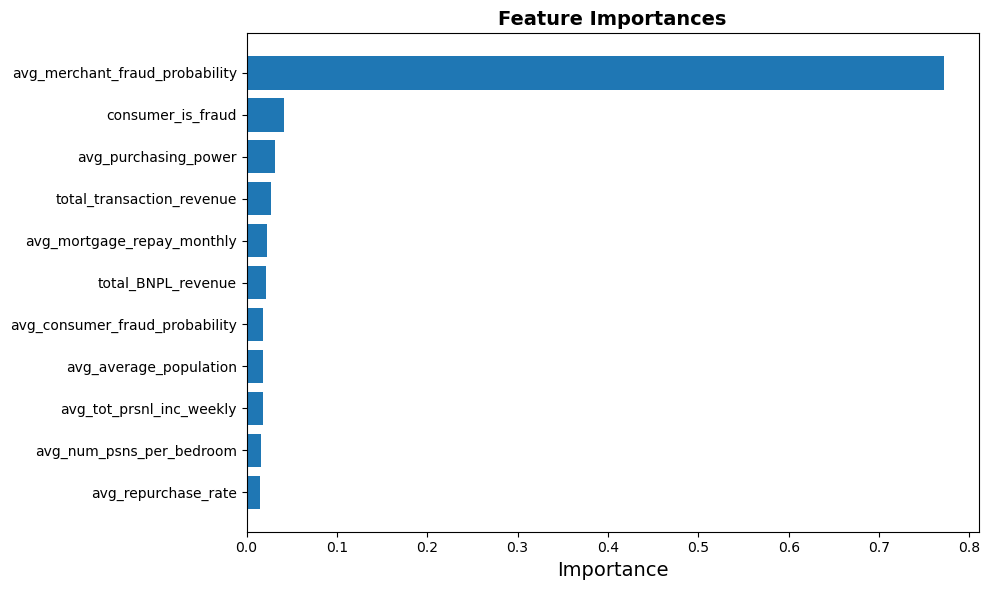

In [111]:
# Using the sorted_feature_importances to create a dictionary
importance_dict = dict(sorted_feature_importances)

# Sort the features and their importances from largest to smallest for the plot
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=False)

# Unpack the sorted features and importances
features_sorted = [x[0] for x in sorted_features]
importances_sorted = [x[1] for x in sorted_features]

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, importances_sorted)
plt.xlabel('Importance', fontsize=14)
plt.title('Feature Importances', fontsize=14, fontweight="bold")
plt.tight_layout()

# save and display the plot
plt.savefig('../plots/ranking_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

### Use Min-Max Scaling to rescale the feature values of above features in 0-100

In [112]:
all_features = [feature for feature, _ in sorted_feature_importances] + ["merchant_abn",
                                                                         "merchant_segment_1", 
                                                                         "merchant_segment_2", 
                                                                         "merchant_segment_3", 
                                                                         "merchant_segment_4",
                                                                         "merchant_segment_5"]
selected_transaction_by_merchant = aggregated_transaction_by_merchant.select(all_features)

In [113]:
# Extract feature names from sorted_feature_importances
feature_names = [feature for feature, _ in sorted_feature_importances]

# Calculate min and max values for the selected features
min_max_values = aggregated_transaction_by_merchant.select(
    *[F.min(col).alias(f'min_{col}') for col in feature_names],
    *[F.max(col).alias(f'max_{col}') for col in feature_names]
).collect()

# Extract the min and max for scaling
min_values = [min_max_values[0][f'min_{col}'] for col in feature_names]
max_values = [min_max_values[0][f'max_{col}'] for col in feature_names]

# Start with the original DataFrame
scaled_transaction_by_merchant = selected_transaction_by_merchant

# Perform scaling for each feature and create new columns with 'scaled_' prefix
for col, min_val, max_val in zip(feature_names, min_values, max_values):
    scaled_transaction_by_merchant = scaled_transaction_by_merchant.withColumn(
        f'scaled_{col}', ((F.col(col) - min_val) / (max_val - min_val) * 100)
    )

# Drop original columns
scaled_transaction_by_merchant = scaled_transaction_by_merchant.drop(*feature_names)

scaled_transaction_by_merchant.show(5)

+------------+------------------+------------------+------------------+------------------+------------------+-------------------------------------+------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_fraud_probability|scaled_consumer_is_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|
+------------+------------------+------------------+------------------+------------------+----

Since higher `scaled_avg_merchant_fraud_probability` means more frequent fraudent behaviours (negative) and 0 for `scaled_consumer_is_fraud` means not fraudent (positive), we will change `scaled_avg_merchant_fraud_probability` to (100-`scaled_avg_merchant_fraud_probability`) and `scaled_consumer_is_fraud` to (100-`scaled_consumer_is_fraud`).

In [114]:
scaled_transaction_by_merchant = scaled_transaction_by_merchant \
    .withColumn('scaled_avg_merchant_fraud_probability', 100 - F.col('scaled_avg_merchant_fraud_probability')) \
    .withColumn('scaled_consumer_is_fraud', 100 - F.col('scaled_consumer_is_fraud'))

scaled_transaction_by_merchant.describe().show()

+-------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------------------------+------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+
|summary|        merchant_abn| merchant_segment_1| merchant_segment_2|merchant_segment_3| merchant_segment_4| merchant_segment_5|scaled_avg_merchant_fraud_probability|scaled_consumer_is_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|
+-------+--------------------+-------------------+----

### Check the shape of scaled dataset

In [115]:
num_rows = scaled_transaction_by_merchant.count()
print(f"Number of rows: {num_rows}")

num_columns = len(scaled_transaction_by_merchant.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 4026
Number of columns: 17


# Compute the Ranking Score for Each Merchant

In [116]:
# Create a dictionary of feature importance for quick look-up
importance_dict = dict(sorted_feature_importances)

# Initialize the ranking score by multiplying each scaled feature by its respective importance
ranking_score_expr = reduce(
    lambda a, b: a + b, 
    [F.col(f'scaled_{col}') * F.lit(importance_dict[col]) for col, _ in sorted_feature_importances]
)

# Add a new column for the ranking score
ranked_transaction_by_merchant = scaled_transaction_by_merchant.withColumn('ranking_score', ranking_score_expr)

# Show the updated DataFrame with ranking scores
ranked_transaction_by_merchant.show(5)

+------------+------------------+------------------+------------------+------------------+------------------+-------------------------------------+------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+------------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_fraud_probability|scaled_consumer_is_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|     ranking_score|
+------------+------------------+------------------+----

# Select Overall Top 100 Merchants

In [117]:
# Rename columns
ranked_transaction_by_merchant = ranked_transaction_by_merchant \
    .withColumnRenamed('scaled_avg_merchant_fraud_probability', 'scaled_avg_merchant_not_fraud_probability') \
    .withColumnRenamed('scaled_consumer_is_fraud', 'scaled_consumer_not_fraud')

In [118]:
# Sort the DataFrame by 'ranking_score' in descending order
sorted_ranked_transaction_by_merchant = ranked_transaction_by_merchant.orderBy(F.col('ranking_score').desc())

# Select the top 100 rows
top_100_ranked_transactions = sorted_ranked_transaction_by_merchant.limit(100)
top_100_ranked_transactions.show(100)

+------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+-----------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_not_fraud_probability|scaled_consumer_not_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|    ranking_score|
+------------+------------------+---------------

In [120]:
non_zero_segment_counts = top_100_ranked_transactions.select(
    [
        F.sum(F.when(F.col(col_name) != 0, 1).otherwise(0)).alias(f'non_zero_{col_name}')
        for col_name in ['merchant_segment_1', 'merchant_segment_2', 'merchant_segment_3', 'merchant_segment_4', 'merchant_segment_5']
    ]
).collect()

# Extract the results into a dictionary for display
non_zero_segment_counts_dict = {f'non_zero_{col_name}': non_zero_segment_counts[0][f'non_zero_{col_name}'] for col_name in ['merchant_segment_1', 'merchant_segment_2', 'merchant_segment_3', 'merchant_segment_4', 'merchant_segment_5']}

# Map column names without the 'non_zero_' prefix to their human-readable names
segment_names = {
    'non_zero_merchant_segment_1': 'Personal Care and Repair Services',
    'non_zero_merchant_segment_2': 'Arts',
    'non_zero_merchant_segment_3': 'Home and Furniture',
    'non_zero_merchant_segment_4': 'Gifts and Souvenirs',
    'non_zero_merchant_segment_5': 'Technology and Electronic Equipment'
}

# Loop through and print the results with the correct segment names
for col_name, count in non_zero_segment_counts_dict.items():
    print(f"Number of merchants in Segment - {segment_names[col_name]}: {count}")

Number of merchants in Segment - Personal Care and Repair Services: 17
Number of merchants in Segment - Arts: 26
Number of merchants in Segment - Home and Furniture: 20
Number of merchants in Segment - Gifts and Souvenirs: 9
Number of merchants in Segment - Technology and Electronic Equipment: 28


# Select Top 10 Merchants for Each Merchant Segment

In [123]:
# Define the merchant segments and their corresponding names
segment_names = {
    'merchant_segment_1': 'Personal Care and Repair Services',
    'merchant_segment_2': 'Arts',
    'merchant_segment_3': 'Home and Furniture',
    'merchant_segment_4': 'Gifts and Souvenirs',
    'merchant_segment_5': 'Technology and Electronic Equipment'
}

# Find top 10 merchants for each merchant segment
for segment, segment_name in segment_names.items():
    # Filter the merchants that belong to the current segment and sort by ranking_score (descending order), then limit to top 10
    top_10_segment = ranked_transaction_by_merchant.filter(F.col(segment) != 0).orderBy(F.col("ranking_score").desc()).limit(10)
    
    # Print the number of merchants in the current segment
    merchant_count = top_10_segment.count()
    print(f"Number of merchants in Segment - {segment_name}: {merchant_count}")
    
    # Show detailed information of the top 10 merchants in the segment
    top_10_segment.show(truncate=False)

Number of merchants in Segment - Personal Care and Repair Services: 10


+------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+-----------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_not_fraud_probability|scaled_consumer_not_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|ranking_score    |
+------------+------------------+---------------

Number of merchants in Segment - Arts: 10


+------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+-----------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_not_fraud_probability|scaled_consumer_not_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|ranking_score    |
+------------+------------------+---------------

Number of merchants in Segment - Home and Furniture: 10


+------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+-----------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_not_fraud_probability|scaled_consumer_not_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|ranking_score    |
+------------+------------------+---------------

Number of merchants in Segment - Gifts and Souvenirs: 10


+------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+-----------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_not_fraud_probability|scaled_consumer_not_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|ranking_score    |
+------------+------------------+---------------

Number of merchants in Segment - Technology and Electronic Equipment: 10


+------------+------------------+------------------+------------------+------------------+------------------+-----------------------------------------+-------------------------+---------------------------+--------------------------------+---------------------------------+-------------------------+-------------------------------------+-----------------------------+-------------------------------+-------------------------------+--------------------------+-----------------+
|merchant_abn|merchant_segment_1|merchant_segment_2|merchant_segment_3|merchant_segment_4|merchant_segment_5|scaled_avg_merchant_not_fraud_probability|scaled_consumer_not_fraud|scaled_avg_purchasing_power|scaled_total_transaction_revenue|scaled_avg_mortgage_repay_monthly|scaled_total_BNPL_revenue|scaled_avg_consumer_fraud_probability|scaled_avg_average_population|scaled_avg_tot_prsnl_inc_weekly|scaled_avg_num_psns_per_bedroom|scaled_avg_repurchase_rate|ranking_score    |
+------------+------------------+---------------